-104.89263258083801
114.19567413976166 114.19567413976166
-4317584.449198884
110.00889920482766 110.00889920482766


/Users/kootsoop/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:85: RuntimeWarning: divide by zero encountered in double_scalars


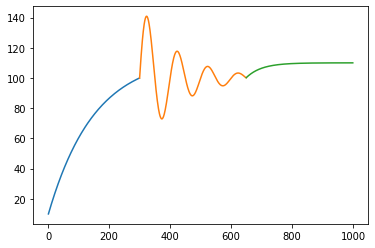

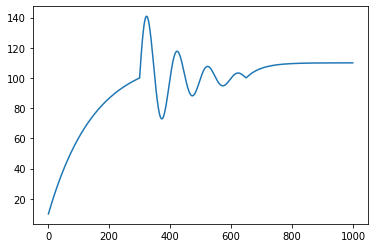

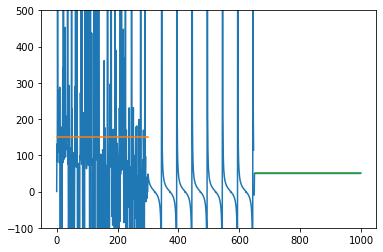

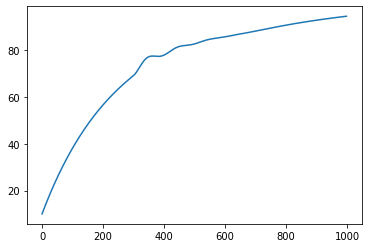

In [3]:
from numpy import log10, asarray, polyfit, ceil, arange, exp, sin, pi, log, random, sum, diff
import matplotlib.pyplot as plt



T = 1000
Ton = 300
Toff = 650


#
# First period: temperature rising or falling as a first order system.
#
# IC @ 1 = min FC @ Ton = max
# f(t) = K1 + K2 exp(-t/tau)
# f(1) = K1 + K2 exp(-1/tau) = min        (1)
# f(Ton) = K1 + K2 exp(-Ton/tau) = max    (2)
#
# (1) - (2) --> K2 ( exp(-1/tau) - exp(-Ton/tau) ) = min - max --> K2 = (min - max) / (exp(-1/tau) - exp(-Ton/tau) )
mx = 100
mn = 10
tau = 150
time_period_1 = list(arange(1,Ton))
K2 = (mn - mx) / (exp(-1/tau) - exp(-Ton/tau))
print(K2)
K1 = mn - K2*exp(-1/tau)
K1_2 = mx - K2*exp(-Ton/tau)
print(str(K1) + " " + str(K1_2))

temperature = [K1 + K2*exp(-x/tau) + random.normal(0,0.001) for x in time_period_1]

plt.figure(1)
plt.plot(time_period_1, temperature)

#
# Second period: being controlled.
#
time_period_2 = list(arange(Ton, Toff))

variation = 50
mean_value = temperature[Ton-2]
tau2 = 120

temperature2 = [variation*sin(2.0*pi*(x/100))*exp(-(x-Ton)/tau2) + mean_value for x in time_period_2]
plt.plot(time_period_2, temperature2)

#
# Third period: back to first order.
#
# IC @ Toff = last value of previous period FC @ T = mx3
# f(t) = K1 + K2 exp(-t/tau)
# f(Toff) = K1 + K2 exp(-Toff/tau) = min        (1)
# f(T) = K1 + K2 exp(-T/tau) = max              (2)
#
# (1) - (2) --> K2 ( exp(-Toff/tau) - exp(-T/tau) ) = last value - mx3
#           --> K2 = (last value - mx) / (exp(-Toff/tau) - exp(-T/tau) )
mx3 = 110
mn3 = temperature2[Toff-Ton-2]
tau2 = 50
time_period_3 = list(arange(Toff, T))

K23 = (mn3 - mx3) / (exp(-Toff/tau2) - exp(-T/tau2))
print(K23)
K13 = mn3 - K23*exp(-Toff/tau2)
K13_2 = mx3 - K23*exp(-T/tau2)
print(str(K13) + " " + str(K13_2))

temperature3 = [K13 + K23*exp(-x/tau2) for x in time_period_3]
plt.plot(time_period_3, temperature3)

all_temps = list(temperature) + list(temperature2) + list(temperature3)

plt.figure(2)
plt.plot(arange(1,T), all_temps)

#
#  K1 + K2 exp(-n/tau) vs K1 + K2 exp(-(n+1)/tau) vs K1 + K2 exp(-(n+2)/tau)
#
# => K2 [ exp(-n/tau)1(1 - exp(-1/tau) ]                (3)
# => K2 [ exp(-n/tau)exp(-1/tau)(1 - exp(-(1/tau) ]     (4)
#
# log(3) - log(4) --> log(exp(-1/tau)) = -1/tau

# Blows up badly with a very small amount of noise!
tau_hat = [-1/(log(abs(all_temps[i+1]-all_temps[i])) - log(abs(all_temps[i]-all_temps[i-1])))  for i in range(len(all_temps)-1)]
                                                 
plt.figure(3)
plt.plot(tau_hat)
plt.plot([0, Ton],[tau, tau])
plt.plot([Toff, T],[tau2, tau2])
plt.ylim(-100,500)

#difference = [(all_temps[i] - all_temps[i+1]) for i in range(len(all_temps)-1)]
#plt.figure(4)
#plt.plot(difference)

plt.figure(4)
mean_value = [sum(all_temps[0:(i+1)])/len(all_temps[0:(i+1)]) for i in range(len(all_temps))]
plt.plot(mean_value)



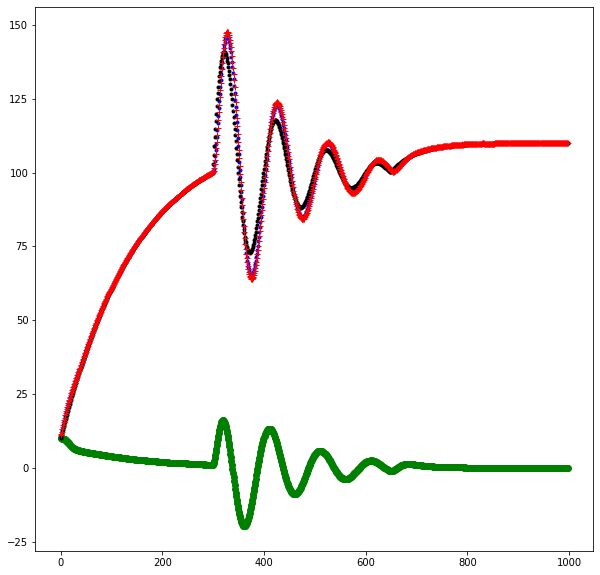

<Figure size 432x288 with 0 Axes>

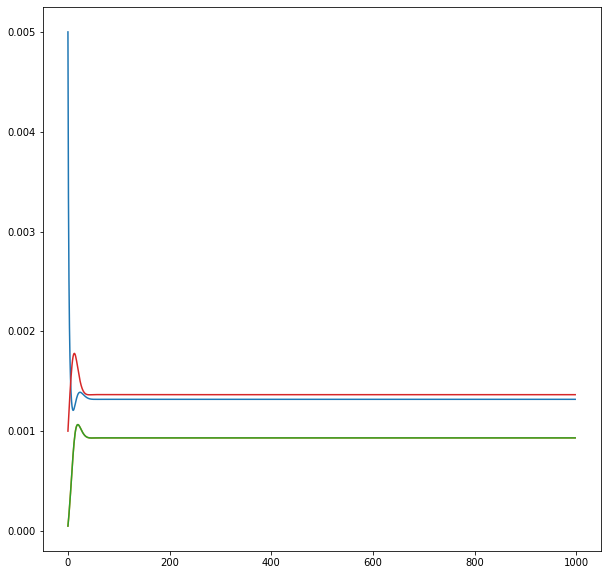

<Figure size 432x288 with 0 Axes>

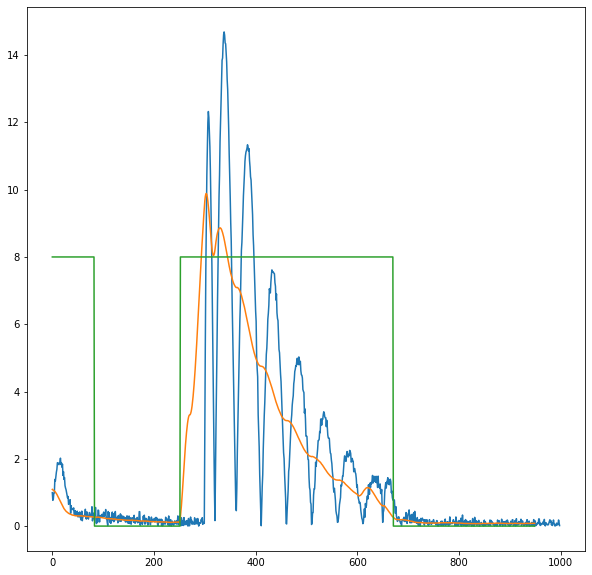

In [79]:
import matplotlib.pyplot as plt
import numpy as np
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise, Saver

dt = 0.1
r_std = 0.1
q_std = 0.1

cv = KalmanFilter(dim_x=2, dim_z=1)
cv.x = np.array([[all_temps[0]], [10.]]) # position, velocity
cv.F = np.array([[1, dt],[0, 1]])
cv.R = np.array([[r_std**2]])
cv.H = np.array([[1., 0.]])
cv.P = np.diag([.1**2, .03**2])
cv.Q = Q_discrete_white_noise(2, dt, q_std**2)

saver = Saver(cv)
for z in range(len(all_temps)):
    cv.predict()
    cv.update([all_temps[z] + random.randn()*q_std ])
    saver.save() # save the filter's state

saver.to_array()
plt.figure(figsize=(10,10))
plt.plot(saver.x[:, 0], 'b.')
plt.plot(saver.x[:, 1], 'go')
plt.plot(all_temps,'k.')

# plot all of the priors
plt.plot(saver.x_prior[:, 0], 'r+')

# plot mahalanobis distance
plt.figure()
plt.figure(figsize=(10,10))
plt.plot(saver.P[:,0,0])
plt.plot(saver.P[:,0,1])
plt.plot(saver.P[:,1,0])
plt.plot(saver.P[:,1,1])

plt.figure()
plt.figure(figsize=(10,10))
plt.plot(abs(saver.y[:,0,0]))

N = 50
smoothed_innovations = np.convolve(abs(saver.y[:,0,0]), np.ones((N,))/N, mode='valid')
plt.plot(smoothed_innovations)
threshold = np.mean(smoothed_innovations[100:200])
standard_deviation = np.std(smoothed_innovations[100:200])

plt.plot(8*(smoothed_innovations > threshold + 3*standard_deviation))

plt.savefig('Q70221.png')
